## Introduction

This notebook is an implementation of the greedy poisoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

In [1]:
import csv
import numpy as np
import pandas as pd
from itertools import groupby

from sklearn.linear_model import LinearRegression
from sklearn import metrics 

#import warnings, datetime
#import scipy.stats as ss

In [2]:
import cProfile

In [3]:
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys, X):
    # we observe that poisoning keys are densly populated together
    # get range for x-axis by looking at first and last element
    plt.hist(poisoning_keys, bins = 100, range=[X[0][0], X[len(X)-1][0]])
    plt.show()

In [4]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

In [5]:
def calculate_mean_squared_error(x, y):
    regressor = LinearRegression()
    regressor.fit(x, y) 
    y_pred = regressor.predict(x)
    print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  
    # Plot outputs
    plt.scatter(x, y,  color='black')
    abline(regressor.coef_, regressor.intercept_, color="blue", label="Regression line")
    plt.show()

## Algorithm 1 - Greedy Poisoning Regression CDF

The following code implements **Algorithm 1 (Greedy Poisoning Regression CDF)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [6]:
"""
Source: Scipy - https://github.com/scipy/scipy/blob/v1.7.0/scipy/stats/stats.py#L8631-L8737
"""
def rankdata(array):
    #arr = np.ravel(np.asarray(array))
    algo = 'mergesort'
    sorter = np.argsort(array, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)
    return inv + 1

In [7]:
########################### Legacy ###########################

# Extracts non-occupied keys for a given sequence
def extract_non_occupied_keys(keyset):
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    # convert to set to speed up lookup
    keyset = set(keyset)
    
    non_occupied_keys = []
    for i in range(lower_bound, upper_bound + 1):
        if i not in keyset :
            non_occupied_keys.append(i)

    return non_occupied_keys

# Groups a list of keys into subsequences of consecutive keys 
def extract_seq(seq):
    return [
        [x for _, x in g]
        for k, g in groupby(
            enumerate(seq), 
            lambda i_x : i_x[0] - i_x[1]
        )
    ]   

# Extract the endpoints of each subsequence
def extract_endpoints(subsequences):
    endpoints = []
    for sequence in subsequences:
        if len(sequence) == 1:
            endpoints.append(sequence[0])
        else:
            endpoints.append(sequence[0]) # get first element of sequence
            endpoints.append(sequence[len(sequence)-1]) # get last element of sequence
            
    return endpoints

# Partition the non-occupied keys, i.e., keys not in K ∪ P, into subsequences such that each subsequence consists of consecutive non-occupied keys;
def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)

    non_occupied_keys = extract_non_occupied_keys(keyset)
    
    subsequences = extract_seq(non_occupied_keys)
    endpoints = extract_endpoints(subsequences)
    # convert list of endpoints to np.array
    return np.array(endpoints)

In [8]:
# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        # PERFORMANCE: conversion to set() not efficient
        #keyset_extended = set(np.append(keyset, endpoint))
        keyset_extended = np.append(keyset, endpoint)
        
        # PERFORMANCE: ss.rankdata is very time-consuming
        #rank = list(ss.rankdata(keyset_extended, method='ordinal'))
        rank = rankdata(keyset_extended)
        
        # extract rank for the last element in the list (the endpoint)
        rank_of_endpoint = rank[len(rank) - 1]
        computed_rank_for_endpoint.append(int(rank_of_endpoint))
    
    return computed_rank_for_endpoint
    

In [21]:
import operator
from statistics import mean

def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys P
    P = int(p * n)
    poisoning_keys = set()
    

    for j in range(P):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        
        # S: endpoints
        S = partition_non_occupied_keys(keyset, poisoning_keys)
        #print("Length of endpoints: ", len(S))

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        # T: list_rank
        T = compute_rank_for_endpoints(S, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;

        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        # insert first potential poisoning key
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(current_keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(current_rankset)

        M_K_square[0] = np.mean(current_keyset**2)

        M_R_square[0] = np.mean(current_rankset**2)

        M_KR[0] = np.mean(current_keyset*current_rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(S)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            M_K_square[i] = M_K_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poisoned keys

In [10]:
df = pd.read_csv('../data/random_5000.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])

Mean Squared Error: 116.1583574718299


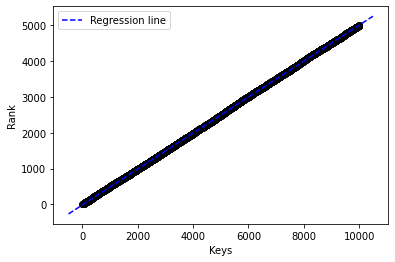

In [11]:
calculate_mean_squared_error(X, y)

## Linear regression with poisoned keys

In [22]:
poisoning_keys = obtain_poisoning_keys(p = 0.05, keyset=X, rankset=y)

Length of endpoints:  3738
Length of endpoints:  3737
Length of endpoints:  3736
Length of endpoints:  3735
Length of endpoints:  3735
Length of endpoints:  3734
Length of endpoints:  3733
Length of endpoints:  3732
Length of endpoints:  3731
Length of endpoints:  3730
Length of endpoints:  3729
Length of endpoints:  3728
Length of endpoints:  3727
Length of endpoints:  3726
Length of endpoints:  3725
Length of endpoints:  3725
Length of endpoints:  3725
Length of endpoints:  3725
Length of endpoints:  3725
Length of endpoints:  3725
Length of endpoints:  3724
Length of endpoints:  3723
Length of endpoints:  3722
Length of endpoints:  3722
Length of endpoints:  3721
Length of endpoints:  3720
Length of endpoints:  3720
Length of endpoints:  3719
Length of endpoints:  3718
Length of endpoints:  3717
Length of endpoints:  3716
Length of endpoints:  3715
Length of endpoints:  3714
Length of endpoints:  3713
Length of endpoints:  3713
Length of endpoints:  3712
Length of endpoints:  3711
L

In [17]:
cProfile.run('obtain_poisoning_keys(p = 0.05, keyset=X, rankset=y)', sort = "time")

         32169816 function calls (30349960 primitive calls) in 52.792 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   909178   12.683    0.000   27.992    0.000 <ipython-input-6-3d51dcaacfe3>:4(rankdata)
   909178    7.883    0.000    7.883    0.000 {method 'argsort' of 'numpy.ndarray' objects}
3640462/1820606    5.835    0.000   22.731    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      250    4.982    0.020   46.836    0.187 <ipython-input-8-c0741cc43033>:2(compute_rank_for_endpoints)
        1    3.745    3.745   52.791   52.791 <ipython-input-9-90dbff4b3c04>:4(obtain_poisoning_keys)
   909178    3.043    0.000    3.043    0.000 {built-in method numpy.arange}
   909928    1.742    0.000   11.373    0.000 function_base.py:4690(append)
   909178    1.430    0.000    1.430    0.000 {built-in method numpy.empty}
  1821606    1.418    0.000    1.418    0.000 {built-in method numpy.array}


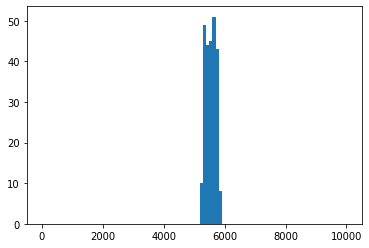

In [18]:
plot_distribution_of_poisoning_keys(poisoning_keys, X)

In [19]:
X_poisoned = np.append(X, list(poisoning_keys))
y_poisoned = rankdata(X_poisoned)
X_poisoned = X_poisoned.reshape(-1,1)

Mean Squared Error: 4562.1294211519635


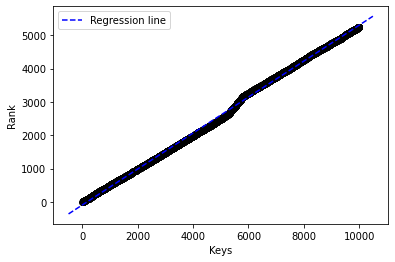

In [20]:
calculate_mean_squared_error(X_poisoned, y_poisoned)

In [18]:
#ratio_loss =  mse_poisoned / mse_legitimates

### Visualization

In [70]:
# Plot outputs
#plt.scatter(X_poisoned, y_poisoned,  color='black')
#abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
#abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
#label= "Poisoned vs. non-poisoned regression line for n="+ str(X.shape[0]) + " keys"
#plt.title(label=label)
#plt.show()

### Write poisoned keyset to file

In [94]:
poisoned_keyset = pd.DataFrame(data=list(X_poisoned))
poisoned_keyset.to_csv("../data/poisoned_keyset_5000.csv", sep=',',index=False)

## Perform poisoning of SOSD benchmark files

In [ ]:
def read_dataset(dataset_filename : str):
    keyset = np.fromfile("../data/" + dataset_filename, dtype=np.uint64)[1:]
    print("Length of keyset: ", len(keyset))
    rankset = rankdata(keyset)
    keyset = keyset.reshape(-1, 1)
    return (keyset, rankset)
    

    
X, y = read_dataset("wiki_ts_1M_uint64")

In [ ]:
calculate_mean_squared_error(X, y)

In [ ]:
X

In [ ]:
y

In [ ]:
poisoning_keys = obtain_poisoning_keys(p = 0.005, keyset=X, rankset=y)

In [ ]:
cProfile.run('obtain_poisoning_keys(p = 0.001, keyset=X, rankset=y)', sort = "time")

In [ ]:
poisoning_keys

In [ ]:
plot_distribution_of_poisoning_keys(poisoning_keys, X)

In [ ]:
X_poisoned = np.append(X, list(poisoning_keys))
y_poisoned = rankdata(X_poisoned)
X_poisoned = X_poisoned.reshape(-1,1)

In [ ]:
calculate_mean_squared_error(X_poisoned, y_poisoned)

In [ ]:
# Plot outputs
#plt.scatter(X_poisoned, y_poisoned,  color='black')
#abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
#abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
#label= "Poisoned vs. non-poisoned regression line for n="+ str(X.shape[0]) + " keys"
#plt.title(label=label)
#plt.show()

## Linear regression experiments with different key sizes / different poisoning percentages

In [15]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

-------------------------
Dataset size:  500
Mean Squared Error: 10.816464904609312
Mean Squared Error: 11.11713079239834
Mean Squared Error: 12.038229273838143
Mean Squared Error: 13.815707106720806
Mean Squared Error: 17.88193188797914
Mean Squared Error: 24.44914795010329
Mean Squared Error: 29.810067013172063
Mean Squared Error: 40.357670960423974
Mean Squared Error: 53.644429094707164
Mean Squared Error: 66.05976278804661
Mean Squared Error: 84.0755512105039
Mean Squared Error: 105.08008239241076
Mean Squared Error: 128.41479806191754
Mean Squared Error: 148.75057197227716
Mean Squared Error: 169.84725277689816


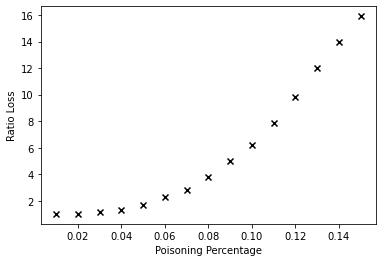

-------------------------
Dataset size:  1000
Mean Squared Error: 20.773564268523586
Mean Squared Error: 25.78819890323834
Mean Squared Error: 38.20042041745141
Mean Squared Error: 56.34731516231744
Mean Squared Error: 76.13307741398904
Mean Squared Error: 104.00910688645017
Mean Squared Error: 137.53844998726439
Mean Squared Error: 188.29765677644156
Mean Squared Error: 243.60929879108775
Mean Squared Error: 307.26563547759065
Mean Squared Error: 379.5819577658792
Mean Squared Error: 459.9276318940463
Mean Squared Error: 527.3773904911287
Mean Squared Error: 609.9754483106909
Mean Squared Error: 708.88213444713


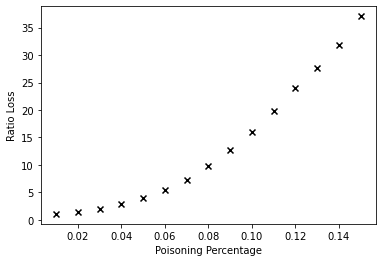

In [16]:
dataset_sizes = [500, 1000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poisoned = np.append(X, list(poisoning_keys))
        y_poisoned = rankdata(X_poisoned)

        X_poisoned = X_poisoned.reshape(-1,1)
        regressor_poisoned = LinearRegression()
        regressor_poisoned.fit(X_poisoned, y_poisoned)  

        y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
        mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)
        ratio_loss =  mse_poisoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()